# Nonlinear regression

## Introduction

From a scientist's point of view, nonlinear regression is a simple extension of linear regression. Nonlinear regression can fit any model that defines Y as a function of X, and the relationship between Y and X can be curved. The methodology is much more complicated and you really can't understand how it works without using matrix algebra and calculus.

Both linear and nonlinear regression find the values of the paramters that minimize the sum of squares of the difference between the actual Y value and the Y value predicted by the regression model. Nonlinearrrr regression uses a computationally intensive approach that can only be explained using calculus and matrix algebra.

It works via an iterative or stepwise approach. In this method, each parameter is initially provided with an estimated value. The idea is to generate an initial curve that goes somewhere in the vicinity of the data points. The nonlinear regression method then changes the values of the parameters to move the curve closer to the points. It repeats these steps many times, which is why the method is called _iterative_. When any possible changes to the parameters would make the curve fit more poorly or fit the same, the method finishes and reports the results.

## The maths

A nonlinear **least-squares** problem is an unconstrained optimization problem of the form
$$ \text{min}(f(x)) = \frac{1}{2} \sum_{i=1}^m{r_i(x)^2}$$
where $n$ is the number of variables. The objective function $f(x)$ is defined by $m$ auxiliary residual functions $r_i(x)$. It uses gradient, Jacobian and Hessian, and the [Gauss-Newton algorithm](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm). Briefly, $ \text{min}(\chi^2) : \nabla \chi^2 = 0$, and for simple linear regression

$$ \nabla \chi^2 = \left [\begin{array}{cc} \frac{\partial \chi^2}{\partial m} \\ \frac{\partial \chi^2}{\partial c} \end{array}\right] = 0$$
where $y = y(x_i;a_i) = m x_i + c$ and the sum of the sqaures of the residuals $r_i = y_i - m x_i - c$, the difference between data items and predicted location on the line $m x + c$, writen $\chi^2 = \sum_{i}{r_i^2} = \sum_i(y_i - m x_i - c)^2$.

Therefore the gradient can be solved explicitely:
$$ \nabla \chi^2 = \left [\begin{array}{cc} -2 \sum_i{x_i(y_i-m x_i - c)} \\ -2 \sum_i{(y_i - m x_i - c)} \end{array}\right] = 0$$

with $$c = \overline{y} - m \overline{x}$$
$$m = \frac{\sum_i(x_i - \overline{x})y_i}{\sum_i(x_i - \overline{x})^2}$$

We also have
$$\sigma_c \simeq \sigma_m \sqrt{\overline{x}^2 + \frac{1}{n} \sum_i{(x_i - \overline{x})^2}}$$
$$\sigma_m^2 \simeq \frac{\chi^2}{\sum_i{(x_i - \overline{x})^2(n-2)}}$$

In general non linear least squares $\chi^2$ minimization, we have $$\chi^2 = \sum_i^n{\frac{(y_i-y(x_i;a_k))^2}{\sigma_i}}$$
We penalize each difference by the uncertainty so that uncertained data points have low weight and won't affect the fit too much.

To reach $\nabla \chi^2 = 0$, the gradient descent algorithm will do $a_{\text{next}} = a_{\text{cur}} - \gamma \nabla \chi^2$, writen differently

$$a_{\text{next}} = a_{\text{cur}} + \gamma \sum_i^n{\frac{(y_i - y(x_i;a_k))}{\sigma_i} \frac{\partial y}{\partial a_k}}$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Nonlinear regression results

### Quick exploration of the data

One assumption for nonlinear regression is that **the independent variable has no variability**, or at least much less variability than the depedent variable, i.e. there will be very little error in pipetting or recording the time at which the sample is taken. Note that the x-axis is logarithmic.


In [2]:
# data from taken from page 367
relaxation = np.array([2.6, 10.5, 15.8, 21.1, 36.8, 57.9, 73.7, 89.5, 94.7, 100, 100])
norepi_log = np.arange(-8, -2.5, .5) # log scale
norepi_lin = 10**norepi_log

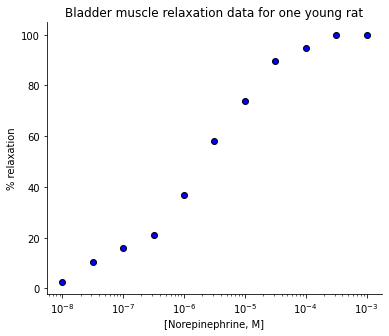

In [3]:
plt.figure(figsize=(6,5))
plt.plot(norepi_lin, relaxation, 'ko', mfc='blue')
plt.title("Bladder muscle relaxation data for one young rat")
plt.xlabel("[Norepinephrine, M]")
plt.xscale('log')
plt.ylabel(r"% relaxation")
sns.despine();

### The model

After choosing a model, the next step is to decide which of the parameters in the model should be fit to the data and which should be fixed to constant values. In this example, muscle relaxation must be zero with no added norepinephrine. So we will tell the model not to find the best-fit value of _Bottom_ but rather to set it to a constant value of zero. We don't want to fix the _Top_ to 100, because the one goal of the study is to see whether that top plateay differs in old and young rats.

$$ Y = \text{Bottom} + \frac{\text{Top} - \text{Bottom}}{1 + 10^{(\log{\text{EC}_{50}} - X) . \text{HillSlope}}} $$

In this equation, $X$ represents the **logarithm** of the concentration of norepinephrine, and $Y$ is the response the investigators measured. $Y$ is defined as a function of $X$ and four **parameters**:

* $\text{Bottom}$ is the value of $Y$ when $X$ is very low, the **baseline** value of $Y$ when there is no drug added
* $\text{Top}$ is the value of $Y$ when $X$ is very high. As the concentration gets higher and higher, the response **plateau** at a value call _Top_
* $\log{\text{EC}_{50}}$ is the value of $X$ that provokes a response **halfway** between _Bottom_ and _Top_
* $\text{HillSlope}$ quantifies how **steep** the curve is


### Best-fit values of parameters using scipy.optimize curve_fit method

In [4]:
from scipy.optimize import curve_fit

def logistic3(x, top,         log_ec50, hill_slope):
    """3PL logistic equation"""
    return (0      + ((top - 0)      / (1 + 10**((log_ec50 - x) * hill_slope))))

def logistic4(x, top, bottom, log_ec50, hill_slope):
    """4PL logistic equation - Used when bottom != 0"""
    return (bottom + ((top - bottom) / (1 + 10**((log_ec50 - x) * hill_slope))))

# initial guess for parameters
p0 = [100, -6, .5] # top, log_ec50, hill_slope

In [5]:
# fit the 3PL model to the data using least squares optimization and initial guess parameters
best_vals, covar = curve_fit(logistic3, norepi_log, relaxation, p0=p0)

print("Best-fit values of parameters (3PL model):")
print("------------------------------------------")
print(f"Top = {      best_vals[0]:.1f}")
print(f"LogEC50 = {  best_vals[1]:.2f}")
print(f"EC50 = { 10**best_vals[1]:.2e}")
print(f"HillSlope = {best_vals[2]:.3f}")

Best-fit values of parameters (3PL model):
------------------------------------------
Top = 104.1
LogEC50 = -5.64
EC50 = 2.30e-06
HillSlope = 0.622


#### Visualization

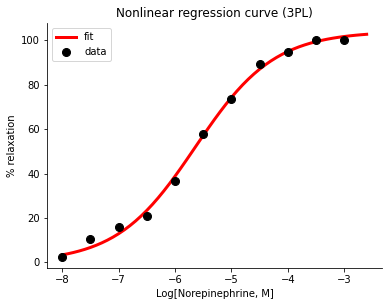

In [6]:
plt.figure(figsize=(6,4.5))
x=np.arange(-8, -2.5, step=.1)
plt.plot(x, logistic3(x, *best_vals), 'r-', lw=3, label='fit') # fitting curve
plt.plot(norepi_log, relaxation, 'ko', label='data', ms=8) # original data points
plt.title("Nonlinear regression curve (3PL)")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel(r"% relaxation")
plt.legend()
sns.despine();

#### Standard errors

The SD of the best-fit parameters are given by the diagonal elements of the covariance matrix $ \sum = \sigma^2(H^{-1})$ where $\sigma$ is the standard deviation of the residuals and $H$ the Hessian of the objective function, i.e. least squares.

We can get an estimate of $\sigma$ with $ \hat{\sigma} = \sqrt{\frac{f(x_{\text{best}})}{m-n}}$ where $f(x_{\text{best}})$ is the best likelihood found by maximum-likelihood (a.k.a. best fit objective function). This can be something like the **sum of squared residuals** (SSE), $m$ is the number of parameters in your model, $n$ is the number of data points used to fit your model.

Therefore this is not the covariance matrix of the variables, but of the estimated parameters, with $\sigma^2$ the variance of the errors around the mean of the predicted points on the OLS line (noise) $$ \text{var}(\hat{\beta}) = \sigma^2(X^{T}X)^{-1} $$ where $$\sigma^2 = \frac{1}{DF}\sum(\text{residuals})^2$$

Prism uses a standard method to compute the standard error and confidence interval for each parameter fit with nonlinear regression. Each parameter's standard error is computed using this equation: $$ \text{SE}(\text{P}_i) = \sqrt{\frac{\text{SSE}}{\text{DF}} . \text{Cov}_{i,i}}$$
where:

* $P_i$: $i$-th adjustable (non-constant) parameter
* $SSE$: sum of squared residuals
* $DF$: degrees of freedom (the number of data points minus number of parameters fit by regression)
* $Cov_{i,i}$: $i$-th diagonal element of covariance matrix


In [7]:
 print(covar.round(3)) # obtained with curve_fit

[[ 4.242e+00  8.300e-02 -5.100e-02]
 [ 8.300e-02  3.000e-03 -1.000e-03]
 [-5.100e-02 -1.000e-03  1.000e-03]]


In the current example, _covar_ is the covariance matrix or inverted Hessian from last iteration, also the covariance of the parameters around the [optimal values](https://www.graphpad.com/guides/prism/7/curve-fitting/index.htm?reg_how_confidence_and_prediction_.htm), e.g. $\sum = \left[ \begin{array}{}\sigma² & cov \\cov & \sigma² \\ \end{array} \right]$. The diagonals provide the variance of the parameter estimate. To compute standard errors/SD on the estimated coefficients use `perr = np.sqrt(np.diag(covar))`


In [7]:
perr = np.sqrt(np.diag(covar)) # this returns the so-called standard error

print("Stadard errors/SD of parameters:")
print("--------------------------------")
print(f"Top = {      perr[0]:.2f}")
print(f"LogEC50 = {  perr[1]:.4f}")
print(f"HillSlope = {perr[2]:.4f}")

Stadard errors/SD of parameters:
--------------------------------
Top = 2.06
LogEC50 = 0.0515
HillSlope = 0.0358


#### Confidence interval estimation

Asymptotic confidence intervals are always centered on the best-fit value of the parameter, and extend the same distance above and below that value. The 95% confidence intervals are computed from $\text{BestFit} \pm t.\text{SE}$, where _BestFit_ is the best fit value for the parameter, _SE_ is its standard error, and _t_ is the critical value from the t-distribution for the desired level of confidence (95% is standard) and the number of degrees of freedom which equals the number of data points minus the number of parameters fit by regression.

With 95% confidence and many degrees of freedom (more than a few dozen), this **multiplier is very close to 1.96**. Note that the value of $t$ is not computed from your data, but is a constant that depends on the confidence level you choose, the number of data points, and the number of parameters.

In [8]:
n = len(norepi_log) # number of data points
p = len(best_vals) # number of parameters fitted

df = n - p # n data points minus parameters fitted
t_ = stats.t(df=df).ppf((1+.95)/2) # two-tailed

def return_ci(estimate, se):
    return (estimate-t_*se, estimate+t_*se)

print("95% CI of parameters:")
print("---------------------")
print(f"df = {df}")
print(f"Top = {      best_vals[0]-t_*perr[0]:3.1f} to {best_vals[0]+t_*perr[0]:3.1f}")
print(f"LogEC50 = {  best_vals[1]-t_*perr[1]:.2f} to {best_vals[1]+t_*perr[1]:.2f}")
print(f"EC50 = {10**(best_vals[1]-t_*perr[1]):.2e} to {10**(best_vals[1]+t_*perr[1]):.2e}")
print(f"HillSlope = {best_vals[2]-t_*perr[2]:.3f} to {best_vals[2]+t_*perr[2]:.3f}")

95% CI of parameters:
---------------------
df = 8
Top = 99.3 to 108.8
LogEC50 = -5.76 to -5.52
EC50 = 1.75e-06 to 3.02e-06
HillSlope = 0.540 to 0.705


If the CI had been very wide, then you would not have determined the parameter very precisely and would not be able to interpret its value. How wide is too wide depends on the context and goals of the experiment.

### Nonlinear regression report using lmfit

In [9]:
from lmfit import Model

gmodel = Model(logistic3)
print(gmodel.param_names)

# set the initial values for parameters with *args
params = gmodel.make_params(top=100, log_ec50=-5, hill_slope=.6)

['top', 'log_ec50', 'hill_slope']


In [10]:
results = gmodel.fit(relaxation, x=norepi_log, params=params) # y parameter first!

#### Reports

In [11]:
print(results.fit_report())

[[Model]]
    Model(logistic3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 11
    # variables        = 3
    chi-square         = 42.9570499
    reduced chi-square = 5.36963124
    Akaike info crit   = 20.9853605
    Bayesian info crit = 22.1790464
[[Variables]]
    top:         104.053067 +/- 2.05950530 (1.98%) (init = 100)
    log_ec50:   -5.63808917 +/- 0.05151681 (0.91%) (init = -5)
    hill_slope:  0.62209862 +/- 0.03579814 (5.75%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(top, log_ec50)        =  0.780
    C(top, hill_slope)      = -0.696
    C(log_ec50, hill_slope) = -0.541


In [12]:
results.params['top'].value

104.0530667445461

In [13]:
results.params

name,value,standard error,relative error,initial value,min,max,vary
top,104.053067,2.05950530,(1.98%),100,-inf,inf,True
log_ec50,-5.63808917,0.05151681,(0.91%),-5,-inf,inf,True
hill_slope,0.62209862,0.03579814,(5.75%),0.6,-inf,inf,True


In [14]:
print(results.ci_report(with_offset=False, ndigits=3))

             99.73%  95.45%  68.27%  _BEST_  68.27%  95.45%  99.73%
 top       :  96.263  99.553 101.954 104.053 106.292 109.260 114.261
 log_ec50  :  -5.840  -5.752  -5.691  -5.638  -5.583  -5.512  -5.395
 hill_slope:   0.485   0.542   0.585   0.622   0.662   0.715   0.803


### Goodness of fit

R² is the fraction of the total variance of Y that is explained by the model. In this example, the curve comes very close to all the data points, so the R² is very high.

In [15]:
rss = (results.residual**2).sum() # same as results.chisqr
print(f"RSS/absolute sum of squares (Chi-square) = {rss:3.1f}")

tss = sum(np.power(relaxation - np.mean(relaxation), 2))

print(f"TSS = {tss:.1f}")

print(f"R² using TSS and RSS = {1 - rss/tss:.3f}")

RSS/absolute sum of squares (Chi-square) = 43.0
TSS = 14917.0
R² using TSS and RSS = 0.997


### Plots

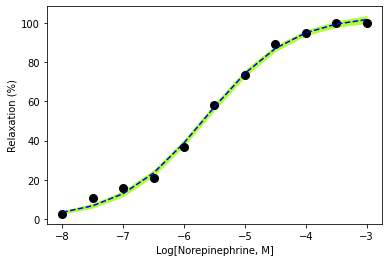

In [16]:
dely = results.eval_uncertainty(x=norepi_log)
plt.plot(norepi_log, relaxation, 'ko', label='data', ms=8) # original data points
plt.plot(norepi_log, results.best_fit, 'b--')
plt.fill_between(
    norepi_log,
    results.best_fit-dely,
    results.best_fit+dely,
    color='greenyellow')
plt.xlabel('Log[Norepinephrine, M]')
plt.ylabel(r'Relaxation (%)'); 

In [17]:
results.best_fit

array([  3.41522906,   6.75771601,  12.95053221,  23.4506351 ,
        38.83502154,  57.15534358,  74.27540269,  87.00941828,
        94.964254  ,  99.40465685, 101.72876687])

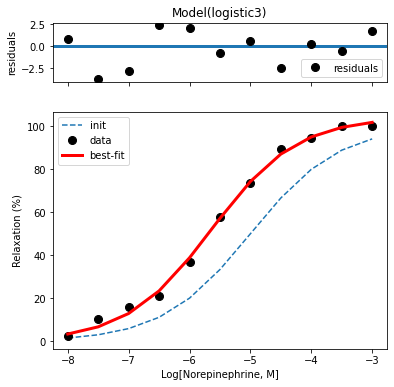

In [18]:
results.plot(     # plot both residuals and fit results
    datafmt='ko',
    fitfmt='r-',
    xlabel='Log[Norepinephrine, M]',
    ylabel=r'Relaxation (%)',
    data_kws={'ms': 8},
    fit_kws={'lw': 3},
    show_init=True); 

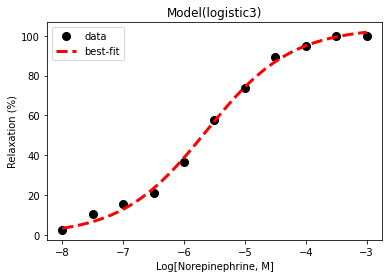

In [19]:
results.plot_fit(
    datafmt='ko',
    fitfmt='r--',
    numpoints=50,
    xlabel='Log[Norepinephrine, M]',
    ylabel=r'Relaxation (%)',
    data_kws={'ms': 8},
    fit_kws={'lw': 3}); # Note every time we refit the model, parameters change

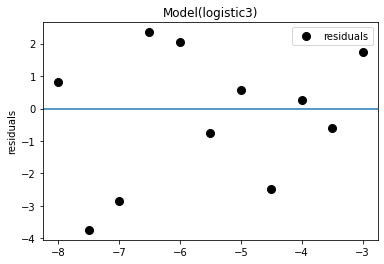

In [20]:
results.plot_residuals(
    datafmt='ko',
    data_kws={'ms': 8},
);

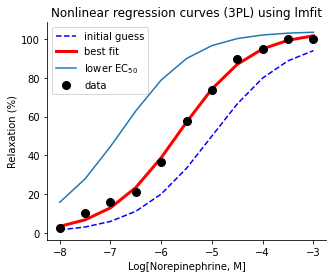

In [22]:
plt.figure(figsize=(5,4))

plt.plot(norepi_log, results.init_fit, 'b--', label='initial guess')
plt.plot(norepi_log, results.best_fit, 'r-',  label='best fit', lw=3)
plt.plot(
        norepi_log,
        results.eval(top=104, log_ec50=-6.8, hill_slope=.622), # evaluation of parameters
        label=r'lower $\rm EC_{50}$'
)

plt.plot(norepi_log, relaxation, 'ko', label='data', ms=8) # original data points

plt.title("Nonlinear regression curves (3PL) using lmfit")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel(r"Relaxation (%)")
plt.legend()
sns.despine();

## Comparing models

We compare the fit of two dose-response models. The second curve represent a fit by a simpler model in which the Hill slope was fixed to a standard value of 1.0. The residuals from the fixed-slope model are on average much larger and not random. In contrast the residuals from the variable slope model are smaller and random (no obvious pattern).

In [23]:
def logistic3_fixHill(x, top, log_ec50):
    """3PL logistic equation with fixed Hill slope"""
    return (0 + ((top - 0) / (1 + 10**((log_ec50 - x) * 1))))

In [24]:
# initiation of the variable slope model
gmodel_1 = Model(logistic3)
print("parameters used in the variable slope model:", gmodel_1.param_names)

# initiation of the fixed slope model
gmodel_2 = Model(logistic3_fixHill)
print("parameters used in the variable fixed model:", gmodel_2.param_names)

parameters used in the variable slope model: ['top', 'log_ec50', 'hill_slope']
parameters used in the variable fixed model: ['top', 'log_ec50']


In [25]:
# initiations of the p0s
params_1 = gmodel_1.make_params(top=100, log_ec50=-5, hill_slope=.6) # variable slope
params_2 = gmodel_2.make_params(top=100, log_ec50=-5)                # fixed slope

# fitting the models to the data
results_1 = gmodel_1.fit(relaxation, x=norepi_log, params=params_1)
results_2 = gmodel_2.fit(relaxation, x=norepi_log, params=params_2)

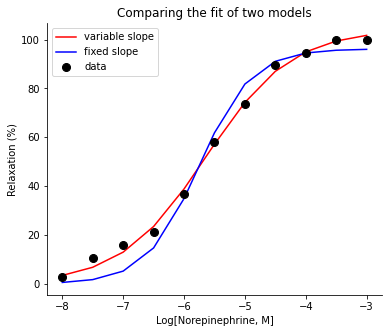

In [26]:
plt.figure(figsize=(6,5))

# let's plot both curves on the same graph
plt.plot(norepi_log, results_1.best_fit, 'r-', label='variable slope')
plt.plot(norepi_log, results_2.best_fit, 'b-', label='fixed slope')

plt.plot(norepi_log, relaxation, 'ko', label='data', ms=8) # original data points

plt.title("Comparing the fit of two models")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel(r"Relaxation (%)")
plt.legend()
sns.despine();

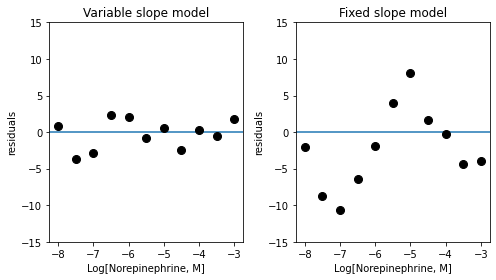

In [27]:
# let's have a look at the residuals
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
ax=results_1.plot_residuals(datafmt='ko', data_kws={'ms': 8})
plt.ylim(-15,15)
plt.xlabel("Log[Norepinephrine, M]")
plt.title("Variable slope model")
ax.get_legend().remove()

plt.subplot(1,2,2)
ax=results_2.plot_residuals(datafmt='ko', data_kws={'ms': 8}) # looks like we show the distance of the curve from the point
plt.ylim(-15,15)
plt.xlabel("Log[Norepinephrine, M]")
plt.title("Fixed slope model")
ax.get_legend().remove()

plt.tight_layout();

In [28]:
results_1.residual

array([ 0.81522906, -3.74228399, -2.84946779,  2.3506351 ,  2.03502154,
       -0.74465642,  0.57540269, -2.49058172,  0.264254  , -0.59534315,
        1.72876687])

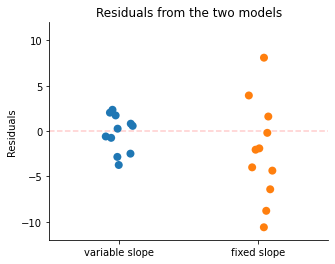

In [29]:
plt.figure(figsize=(5,4))
sns.stripplot(data=[results_1.residual, results_2.residual], size=8)
plt.xticks([0,1], ['variable slope', 'fixed slope'])
plt.ylabel("Residuals")
plt.title("Residuals from the two models")
plt.ylim(-12, 12)
plt.axhline(0, linestyle='--', color='red', alpha=.2)
sns.despine();

### Computing an F ratio and P value from the fits of the two models

The null hypothesis is that the simpler model (fixed slope, one fewer parameter to fit) is correct. In fact the alternative model fits much better (lower sum of squares) but has **one fewer df**. The calculations balance the difference in df with the difference in SS.

In [32]:
print(f"Sum of squares for the fixed slope model (H0): {  results_2.chisqr:4.1f}")
print(f"Degrees of freedom for the fixed slope model: {   results_2.nfree}")
print(f"Sum of squares for the variable slope model: {    results_1.chisqr:4.1f}")
print(f"Degrees of freedom for the variable slope model: {results_1.nfree}")

Sum of squares for the fixed slope model (H0): 358.1
Degrees of freedom for the fixed slope model: 9
Sum of squares for the variable slope model: 43.0
Degrees of freedom for the variable slope model: 8


| Hypothesis  | Scatter from   | Sum squares | df |
|:----------- |:-------------- |:----------- |:-- |
| Null        | Fixed slope    |    358.1    | 9  |
| Alternative | Variable slope |     43.0    | 8  |
| Difference  | Improvement    |    315.1    | 1  |


#### Computing an F ratio and P value from the fits of the 2 models

In [35]:
MS_diff = (results_2.chisqr - results_1.chisqr) / (results_2.nfree - results_1.nfree)
MS_var = results_1.chisqr / results_1.nfree
F_ratio = MS_diff / MS_var
print(f"F ratio : {F_ratio:.2f}")

F ratio : 58.69


| Source variation | Sum squares | DF | MS    | F ratio | P value |
|:---------------- |:----------- |:-- |:----- |:------- |:------- |
| Difference       |    315.1    | 1  | 315.1 |  58.7   | <0.0001 |
| Variable slope   |     43.0    | 8  |   5.4 |         |         |
| Fixed slope      |    358.1    | 9  |       |         |         |

In [40]:
dfn, dfd = results_2.nfree - results_1.nfree, results_1.nfree
p_value= 1 - stats.f(dfn, dfd).cdf(F_ratio)
print(f"P values computed from the F ratio distribution: {p_value:5.5f}")

F_crit = stats.f(dfn, dfd).ppf(.95)
print(f"Critical value computed from the F ratio distribution = {F_crit:.1f}")

P values computed from the F ratio distribution: 0.00006
Critical value computed from the F ratio distribution = 5.3


If the fixed-slope model were correct, it is possible that random scatter of points made the curve fit so badly, but since the P value is less than 0.0001, this would happen less than 0.01% of the time. The low P value is strong evidence that the simple model is inadequate, and that more complicated model in which the program fits the Hill slope is preferable.

#### Visualization of the F distribution

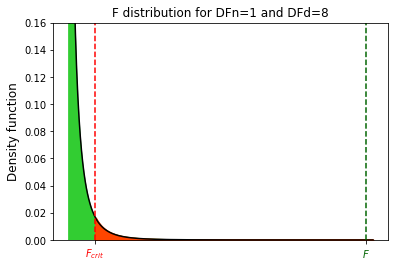

In [44]:
x = np.linspace(0, 60, num=500)
rvf = stats.f(dfn, dfd)
plt.plot(x, rvf.pdf(x), color='black')
hx = rvf.pdf(x)

plt.margins(y = 0)
plt.ylim((0, .16))

# Shade the probability p-value
plt.fill_between(x[x <= F_ratio], hx[x <= F_ratio], edgecolor = None, color = 'limegreen')
# plot the observed F ratio
plt.axvline(x = F_ratio, color = "darkgreen", linestyle = "--")
# Shade the probability alpha
plt.fill_between(
    x[x >= F_crit], hx[x >= F_crit], 
    edgecolor = "orangered", linestyle = "-", linewidth = 2, facecolor = 'orangered')

# plot the critical F value
plt.axvline(x = F_crit, color = "red", linestyle = "--")

ax=plt.gca()
ax.set_xticks([F_crit, F_ratio])
ax.set_xticklabels(["$F_{crit}$", "$F$"], fontdict={'size': 10})
ax.get_xticklabels()[0].set_color("red")
ax.get_xticklabels()[1].set_color("darkgreen")
plt.ylabel('Density function', fontdict={'size': 12})
plt.title(f"F distribution for DFn={dfn} and DFd={dfd}");

## Bootstrapping (a tentative)

In [37]:
gmodel_3 = Model(logistic3)
params_3 = gmodel_3.make_params(top=100, log_ec50=-5, hill_slope=.6)
results_3 = gmodel_3.fit(relaxation, x=norepi_log, params=params_3)

size=10000
inds = np.arange(len(norepi_log))
bs_top_reps = np.empty(size)
bs_log_ec50_reps = np.empty(size)
bs_hill_slope_reps = np.empty(size)

for _ in range(size):
    bs_inds = np.random.choice(inds, len(inds))
    bs_x, bs_y = norepi_log[bs_inds], relaxation[bs_inds]
    results_3.fit(bs_y, x=bs_x, params=params_3)
    bs_top_reps[_] = results_3.params['top'].value
    bs_log_ec50_reps[_] = results_3.params['log_ec50'].value
    bs_hill_slope_reps[_] = results_3.params['hill_slope'].value

In [38]:
print("CI for paramter 'Top': ",      np.percentile(bs_top_reps,        [2.5, 97.5]))
print("CI for paramter 'LogEC50': ",  np.percentile(bs_log_ec50_reps,   [2.5, 97.5]))
print("CI for paramter 'HillSlope': ",np.percentile(bs_hill_slope_reps, [2.5, 97.5]))

CI for paramter 'Top':  [1.03465143e+02 7.82589657e+07]
CI for paramter 'LogEC50':  [ -5.65009107 188.07072514]
CI for paramter 'HillSlope':  [0.23359879 0.63515223]


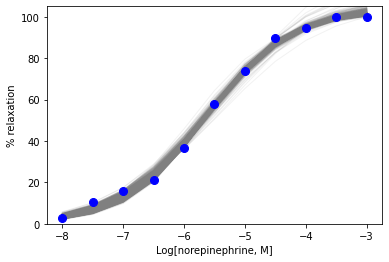

In [39]:
# plot the 500 first pairs of parameters
for _ in range(500):
    plt.plot(
        norepi_log,
        logistic3(
            norepi_log, bs_top_reps[_],
            log_ec50=bs_log_ec50_reps[_],
            hill_slope=bs_hill_slope_reps[_]
        ),
        color='grey',
        lw=1, 
        alpha=.1
    )

plt.plot(norepi_log, relaxation, 'bo', linestyle='None', ms=8) # original data
plt.xlabel('Log[norepinephrine, M]')
plt.ylabel(r'% relaxation')
plt.ylim((0, 105));